<CENTER>
<p><font size="5"> Big Data </span></p>
<p><font size="5"> HMEQ DATASET </font></p>
</p>
</CENTER>

<span style="border-bottom: 2px solid orange;">INTRODUCTION : </span>



In [57]:
# We import the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

#For our classification model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Evaluation metrics
from sklearn.metrics import (
    confusion_matrix,           # Counts of TP, TN, FP, FN
    classification_report,      # Precision, recall, F1 summary
    roc_curve, auc,            # ROC curve and AUC
    roc_auc_score,             # AUC score directly
    ConfusionMatrixDisplay     # Visualization
)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

In [58]:
# Load the whole dataset

df_hmeq = pd.read_csv("raw_data/hmeq.csv")
print(f"Dataset SHape : {df_hmeq.shape}")
print(f"Here are the columns : {df_hmeq.columns.to_list()}")
df_hmeq.head()

Dataset SHape : (5960, 13)
Here are the columns : ['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [59]:
print("Target variable distribution:")
print(df_hmeq['BAD'].value_counts())
print(f"\nDefault rate: {df_hmeq['BAD'].mean():.1%}")
print(f"  - Non-defaults: {(df_hmeq['BAD']==0).sum():,}")
print(f"  - Defaults: {(df_hmeq['BAD']==1).sum():,}")

Target variable distribution:
BAD
0    4771
1    1189
Name: count, dtype: int64

Default rate: 19.9%
  - Non-defaults: 4,771
  - Defaults: 1,189


In [60]:
df_hmeq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [61]:
num_cols = df_hmeq.select_dtypes(include=['float64', 'int64']) 
cat_cols = df_hmeq.select_dtypes(include=['object']) 

print("Numeric Variables:")
print(num_cols.columns.tolist())

print("\nCategorical Variables:")
print(cat_cols.columns.tolist())

Numeric Variables:
['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

Categorical Variables:
['REASON', 'JOB']


We can already see that some data is missing (row "count"). This is a serious problem because if some rows are taking into account for the traning of our model, that could alter the F1 score. Most of the data is numerical and only two columns are strings : REASON and JOB ! 

In [62]:
for col in cat_cols:
    print('We Have {} Unique Values. Values in the {} Column: {}'.format(len(df_hmeq[col].unique()),col,df_hmeq[col].unique()))
    print('__'*30)



We Have 3 Unique Values. Values in the REASON Column: ['HomeImp' nan 'DebtCon']
____________________________________________________________
We Have 7 Unique Values. Values in the JOB Column: ['Other' nan 'Office' 'Sales' 'Mgr' 'ProfExe' 'Self']
____________________________________________________________


In [63]:
print("The count of the missing values for each variable :")
df_hmeq.isnull().sum()

The count of the missing values for each variable :


BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

<span style="border-bottom: 2px solid lime;">Distributions for continuous variables : </span> LOAN (with no null values), MORTDUE, VALUE, YOJ, CLAGE, DEBTINC

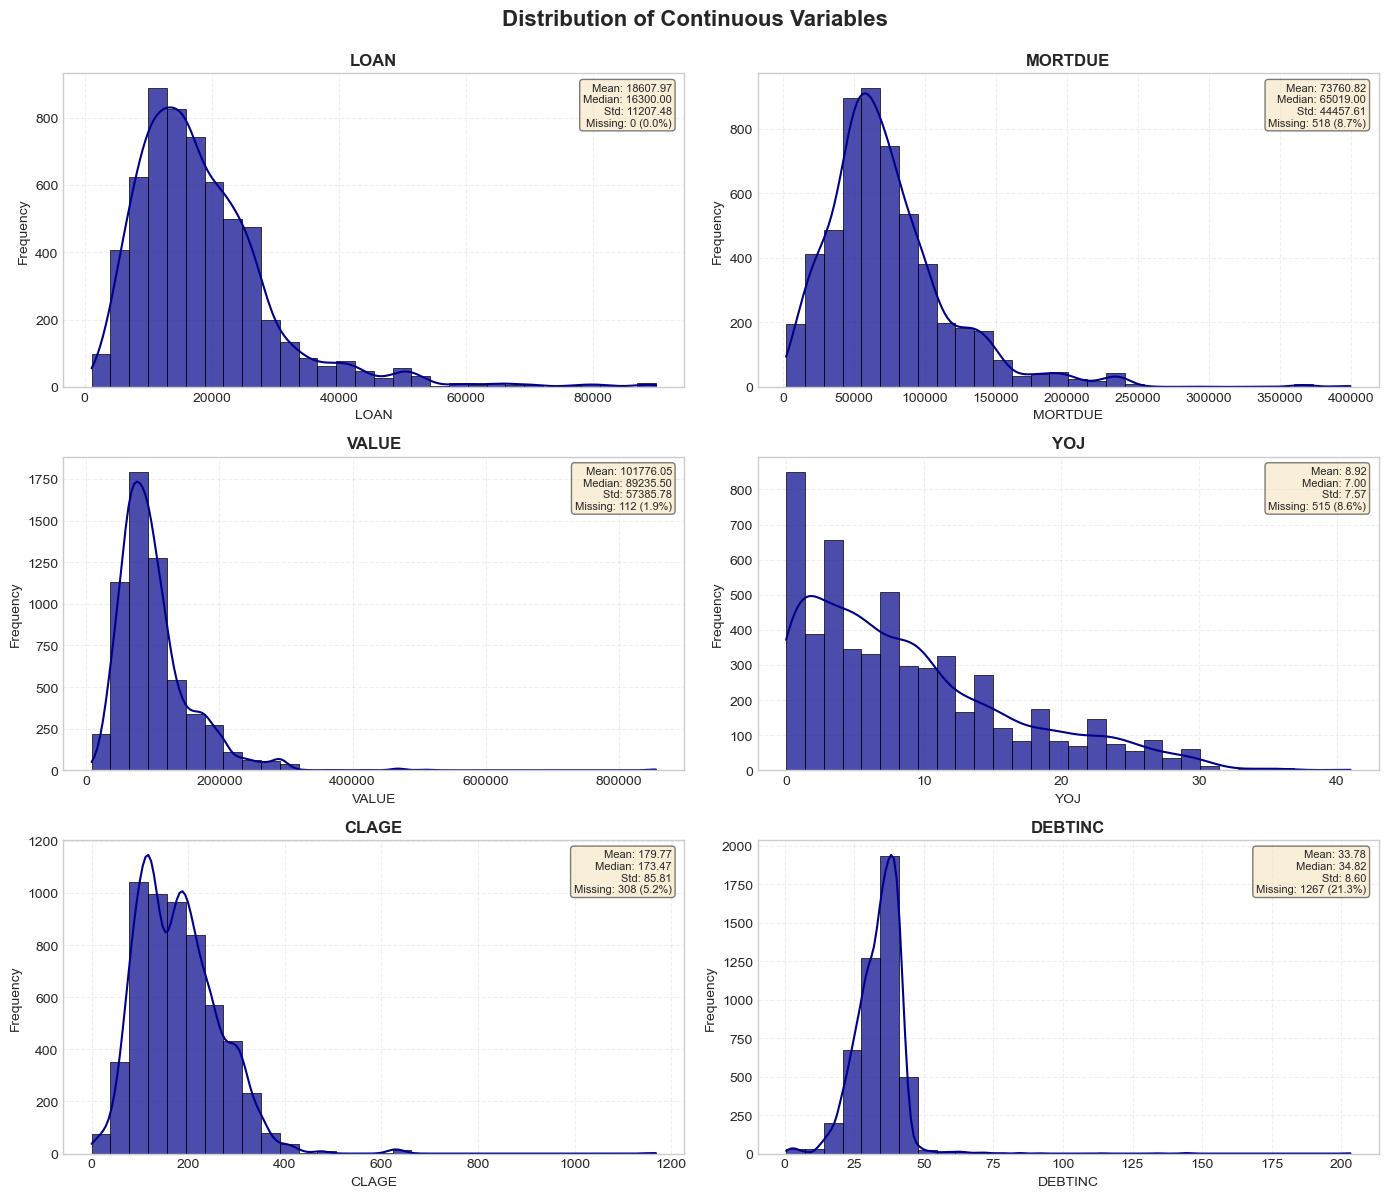

In [99]:
continuous_var = ["LOAN", "MORTDUE", "VALUE", "YOJ", "CLAGE", "DEBTINC"]

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Distribution of Continuous Variables', fontsize=16, fontweight='bold', y=0.995)
axes = axes.flatten()

for idx, var in enumerate(continuous_var):
    data_clean = df_hmeq[var].dropna()
    
    sb.histplot(data=data_clean, bins=30, kde=True, ax=axes[idx], 
                color='darkblue', edgecolor='black', linewidth=0.5, alpha=0.7)
    
    # Add statistics text
    mean_val = data_clean.mean()
    median_val = data_clean.median()
    std_val = data_clean.std()
    missing = df_hmeq[var].isnull().sum()
    missing_pct = (missing / len(df_hmeq)) * 100
    
    # Format the title and labels
    axes[idx].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(var, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    
    # Add statistics as text box
    stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd: {std_val:.2f}\nMissing: {missing} ({missing_pct:.1f}%)'
    axes[idx].text(0.98, 0.97, stats_text, transform=axes[idx].transAxes,
                   fontsize=8, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Grid for better readability
    axes[idx].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

<span style="border-bottom: 2px solid lime;"> For discrete variables : </span> DEROG, DELINQ, NINQ, CLNO

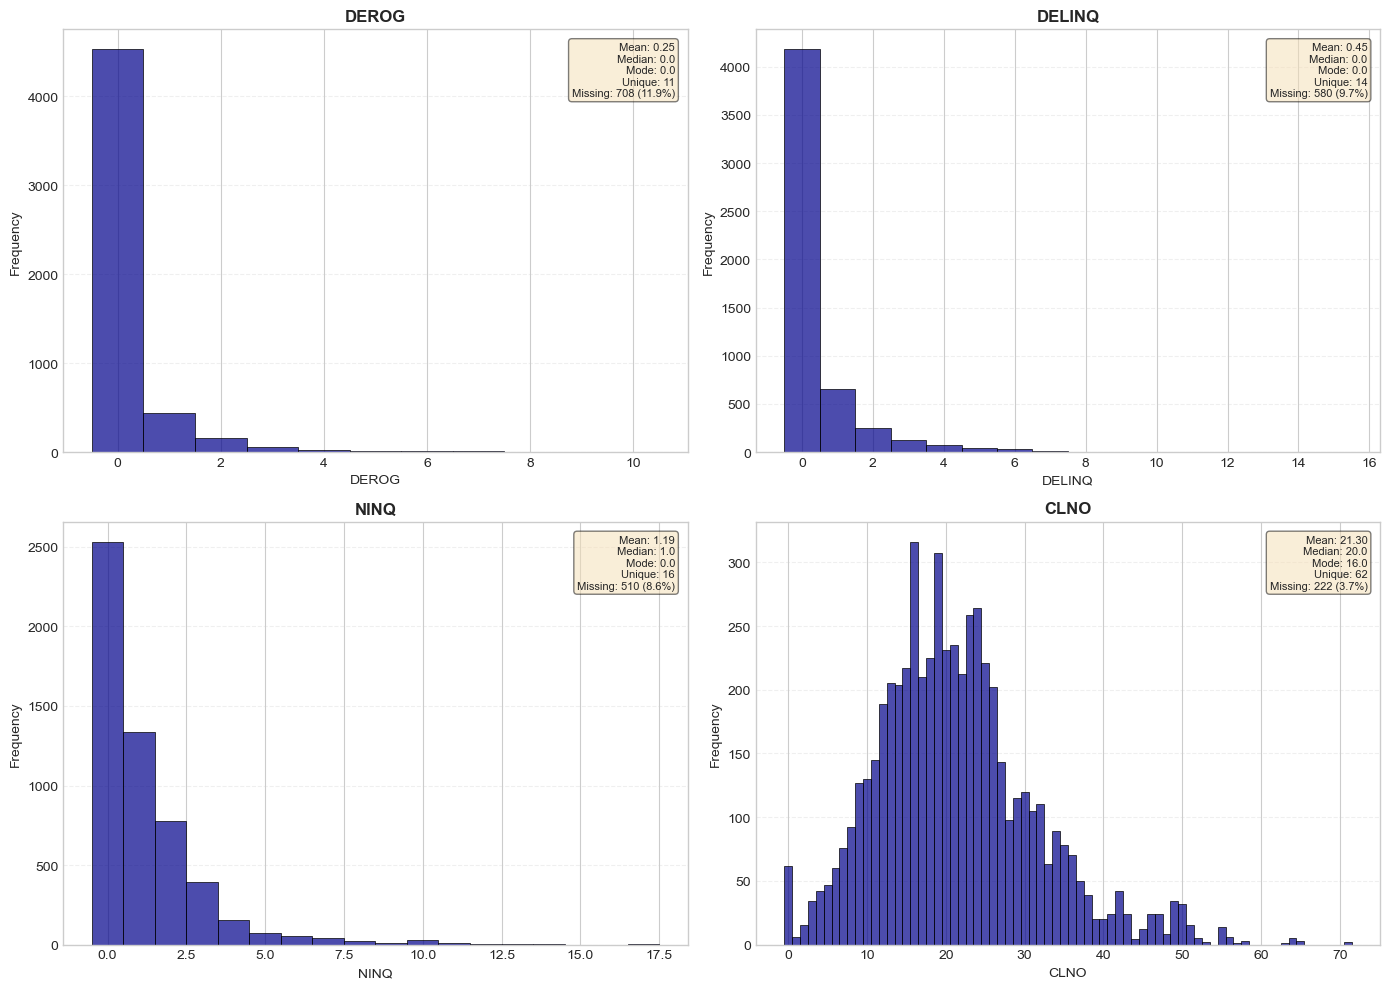

In [98]:
# Create cleaned histograms for discrete variables
discrete_var = ["DEROG", "DELINQ", "NINQ", "CLNO"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, var in enumerate(discrete_var):
    data_clean = df_hmeq[var].dropna()
    sb.histplot(data=data_clean, discrete=True, ax=axes[idx], 
                color='darkblue', edgecolor='black', linewidth=0.5, alpha=0.7)
    
    mean_val = data_clean.mean()
    median_val = data_clean.median()
    mode_val = data_clean.mode()[0] if len(data_clean.mode()) > 0 else 'N/A'
    missing = df_hmeq[var].isnull().sum()
    missing_pct = (missing / len(df_hmeq)) * 100
    unique_vals = data_clean.nunique()
    
    axes[idx].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(var, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    
    stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.1f}\nMode: {mode_val}\nUnique: {unique_vals}\nMissing: {missing} ({missing_pct:.1f}%)'
    axes[idx].text(0.98, 0.97, stats_text, transform=axes[idx].transAxes,
                   fontsize=8, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Grid for better readability
    axes[idx].grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.show()


<span style="border-bottom: 2px solid lime;"> For categorical variables : </span> REASON, JOB

In [66]:
# Frequency tables for categorical variables
categorical_var = ["REASON", "JOB"]

print("="*80)
print("FREQUENCY TABLES FOR CATEGORICAL VARIABLES")
print("="*80)

for var in categorical_var:
    print(f"\n{var} - Frequency Table:")
    print("-"*80)
    
    # Calculate frequencies
    freq_table = df_hmeq[var].value_counts(dropna=False)
    freq_pct = df_hmeq[var].value_counts(normalize=True, dropna=False) * 100
    
    # Create a DataFrame for better display
    freq_df = pd.DataFrame({
        'Value': freq_table.index,
        'Count': freq_table.values,
        'Percentage': freq_pct.values
    })
    
    # Format the percentage column
    freq_df['Percentage'] = freq_df['Percentage'].apply(lambda x: f"{x:.2f}%")
    
    # Replace NaN with 'Missing' for display
    freq_df['Value'] = freq_df['Value'].fillna('Missing')
    
    # Add total row
    total_count = df_hmeq[var].count()
    missing_count = df_hmeq[var].isnull().sum()
    total_rows = len(df_hmeq)
    
    print(freq_df.to_string(index=False))
    print("-"*80)
    print(f"Total observations: {total_rows}")
    print(f"Non-missing: {total_count} ({(total_count/total_rows)*100:.2f}%)")
    print(f"Missing: {missing_count} ({(missing_count/total_rows)*100:.2f}%)")
    print("="*80)

FREQUENCY TABLES FOR CATEGORICAL VARIABLES

REASON - Frequency Table:
--------------------------------------------------------------------------------
  Value  Count Percentage
DebtCon   3928     65.91%
HomeImp   1780     29.87%
Missing    252      4.23%
--------------------------------------------------------------------------------
Total observations: 5960
Non-missing: 5708 (95.77%)
Missing: 252 (4.23%)

JOB - Frequency Table:
--------------------------------------------------------------------------------
  Value  Count Percentage
  Other   2388     40.07%
ProfExe   1276     21.41%
 Office    948     15.91%
    Mgr    767     12.87%
Missing    279      4.68%
   Self    193      3.24%
  Sales    109      1.83%
--------------------------------------------------------------------------------
Total observations: 5960
Non-missing: 5681 (95.32%)
Missing: 279 (4.68%)


In [67]:
# Creation of dummies variable from categorical variables

# First, fill missing values with 'Missing' category to preserve information
df_hmeq['REASON'] = df_hmeq['REASON'].fillna('Missing')
df_hmeq['JOB'] = df_hmeq['JOB'].fillna('Missing')

# Create dummy variables with drop_first=True to avoid multicollinearity
df_encoded = pd.get_dummies(df_hmeq, columns=['REASON', 'JOB'], drop_first=True) # Each categorical variable gets its own reference category

print("Encoded dataset shape:", df_encoded.shape)
print("\nNew dummy variable columns created:")
print(df_encoded.columns.tolist())
print(df_encoded.head(10))

Encoded dataset shape: (5960, 19)

New dummy variable columns created:
['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'REASON_HomeImp', 'REASON_Missing', 'JOB_Missing', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']
   BAD  LOAN  MORTDUE     VALUE  ...  JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self
0    1  1100  25860.0   39025.0  ...       True        False      False     False
1    1  1300  70053.0   68400.0  ...       True        False      False     False
2    1  1500  13500.0   16700.0  ...       True        False      False     False
3    1  1500      NaN       NaN  ...      False        False      False     False
4    0  1700  97800.0  112000.0  ...      False        False      False     False
5    1  1700  30548.0   40320.0  ...       True        False      False     False
6    1  1800  48649.0   57037.0  ...       True        False      False     False
7    1  1800  28502.0   43034.0  ...       True        Fa

<span style="border-bottom: 2px solid lime;"> Missing Data Imputation for Numerical Variables </span>

In [68]:
# Imputation of missing values for numerical variables
# Using median for continuous variables and mode for discrete variables

# Define continuous and discrete variables
continuous_vars = ["MORTDUE", "VALUE", "YOJ", "CLAGE", "DEBTINC"]
discrete_vars = ["DEROG", "DELINQ", "NINQ", "CLNO"]

# Check missing values before imputation
print("\nMissing values BEFORE imputation:")

all_numeric_vars = continuous_vars + discrete_vars
for var in all_numeric_vars:
    missing_count = df_encoded[var].isnull().sum()
    missing_pct = (missing_count / len(df_encoded)) * 100
    print(f"{var:15} : {missing_count:4} ({missing_pct:5.2f}%)")

# Impute continuous variables with MEDIAN
print("\n" + "="*80)
print("CONTINUOUS VARIABLES - Median Imputation")
print("="*80)
for var in continuous_vars:
    median_val = df_encoded[var].median()
    df_encoded[var] = df_encoded[var].fillna(median_val)
    print(f"{var:15} : Imputed with median = {median_val:.2f}")

# Impute discrete variables with MODE
print("\n" + "="*80)
print("DISCRETE VARIABLES - Mode Imputation")
print("="*80)
for var in discrete_vars:
    mode_val = df_encoded[var].mode()[0]
    df_encoded[var] = df_encoded[var].fillna(mode_val)
    print(f"{var:15} : Imputed with mode = {mode_val}")

# Verify no missing values remain
print("\n" + "="*80)
print("Missing values AFTER imputation:")
print("-"*80)
for var in all_numeric_vars:
    missing_count = df_encoded[var].isnull().sum()
    print(f"{var:15} : {missing_count:4} missing values")

print("\n" + "="*80)
print(f"Total missing values in dataset: {df_encoded.isnull().sum().sum()}")
print("="*80)


Missing values BEFORE imputation:
MORTDUE         :  518 ( 8.69%)
VALUE           :  112 ( 1.88%)
YOJ             :  515 ( 8.64%)
CLAGE           :  308 ( 5.17%)
DEBTINC         : 1267 (21.26%)
DEROG           :  708 (11.88%)
DELINQ          :  580 ( 9.73%)
NINQ            :  510 ( 8.56%)
CLNO            :  222 ( 3.72%)

CONTINUOUS VARIABLES - Median Imputation
MORTDUE         : Imputed with median = 65019.00
VALUE           : Imputed with median = 89235.50
YOJ             : Imputed with median = 7.00
CLAGE           : Imputed with median = 173.47
DEBTINC         : Imputed with median = 34.82

DISCRETE VARIABLES - Mode Imputation
DEROG           : Imputed with mode = 0.0
DELINQ          : Imputed with mode = 0.0
NINQ            : Imputed with mode = 0.0
CLNO            : Imputed with mode = 16.0

Missing values AFTER imputation:
--------------------------------------------------------------------------------
MORTDUE         :    0 missing values
VALUE           :    0 missing values
Y

<span style="border-bottom: 2px solid lime;"> Train/Test Split and Feature Scaling </span>

In [82]:
# Train/Test Split and Feature Scaling
# Only scale continuous/discrete numerical variables, NOT binary dummy variables

# 1. Separate features (X) and target (y)
X = df_encoded.drop('BAD', axis=1)
y = df_encoded['BAD']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Preserve class distribution
)

print(f"\nTrain/Test split:")
print(f"  - Train size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Test size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"  - Train target distribution: {y_train.value_counts().to_dict()}")
print(f"  - Test target distribution: {y_test.value_counts().to_dict()}")

continuous_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'DEBTINC', 
                   'DEROG', 'DELINQ', 'NINQ', 'CLNO']
dummy_cols = ['REASON_HomeImp', 'REASON_Missing', 'JOB_Missing', 'JOB_Office', 
              'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']


scaler = StandardScaler()

X_train_continuous_scaled = scaler.fit_transform(X_train[continuous_cols])

# Transform TEST using the same scaler (NO FITTING on test!)
X_test_continuous_scaled = scaler.transform(X_test[continuous_cols])

X_train_continuous_scaled = pd.DataFrame(
    X_train_continuous_scaled, 
    columns=continuous_cols, 
    index=X_train.index
)

X_test_continuous_scaled = pd.DataFrame(
    X_test_continuous_scaled, 
    columns=continuous_cols, 
    index=X_test.index
)

# 6. Combine scaled continuous + unscaled dummies
X_train_scaled = pd.concat([X_train_continuous_scaled, X_train[dummy_cols]], axis=1)
X_test_scaled = pd.concat([X_test_continuous_scaled, X_test[dummy_cols]], axis=1)

# Convert boolean dummy columns to int (0 and 1)
X_train_scaled[dummy_cols] = X_train_scaled[dummy_cols].astype(int)
X_test_scaled[dummy_cols] = X_test_scaled[dummy_cols].astype(int)

print(f"\nFinal scaled datasets:")
print(f"  - X_train_scaled shape: {X_train_scaled.shape}")
print(f"  - X_test_scaled shape: {X_test_scaled.shape}")
print(f"  - y_train shape: {y_train.shape}")
print(f"  - y_test shape: {y_test.shape}")

# Display first few rows to verify
print("\nFirst 5 rows of X_train_scaled:")
print(X_train_scaled.head())


Train/Test split:
  - Train size: 4768 (80.0%)
  - Test size: 1192 (20.0%)
  - Train target distribution: {0: 3817, 1: 951}
  - Test target distribution: {0: 954, 1: 238}

Final scaled datasets:
  - X_train_scaled shape: (4768, 18)
  - X_test_scaled shape: (1192, 18)
  - y_train shape: (4768,)
  - y_test shape: (1192,)

First 5 rows of X_train_scaled:
          LOAN   MORTDUE     VALUE  ...  JOB_ProfExe  JOB_Sales  JOB_Self
609  -0.964574 -0.058206 -0.346217  ...            0          1         0
4015  0.219783 -0.571361 -0.526317  ...            0          0         0
1591 -0.626186 -0.231062 -0.359731  ...            0          0         0
1127 -0.768665 -0.415236 -0.514574  ...            0          0         0
920  -0.848809 -0.604069  0.063615  ...            1          0         0

[5 rows x 18 columns]


<span style="border-bottom: 2px solid orange;">TRAINING / CLASSIFICATION MODELS : </span> we are implementing logistic regression / random forest / gradient boosting at first


In [78]:
logreg = LogisticRegression(
    penalty='l2',               # L2 regularization (Ridge-style)
    C=1.0,                      # Inverse regularization strength
    class_weight='balanced',    # Handle class imbalance
    max_iter=1000,              # Ensure convergence
    random_state=42
)

# Fit on scaled training data
logreg.fit(X_train_scaled, y_train)

print("Logistic Regression fitted!")

Logistic Regression fitted!


In [83]:
rf = RandomForestClassifier(
    n_estimators=200,          # Number of trees
    max_depth=10,              # Limit tree depth to prevent overfitting
    min_samples_leaf=20,       # Minimum samples per leaf
    class_weight='balanced',   # Handle class imbalance
    random_state=42,
    n_jobs=-1                  # Use all CPU cores
)

# Fit on unscaled data (trees don't need scaling)
rf.fit(X_train, y_train)

print("Random Forest fitted!")

Random Forest fitted!


In [84]:
gb = GradientBoostingClassifier(
    n_estimators=200,          # Number of boosting rounds
    max_depth=4,               # Keep trees shallow
    learning_rate=0.1,         # Shrinkage factor
    subsample=0.8,             # Stochastic gradient boosting
    random_state=42
)

# Fit the model
gb.fit(X_train, y_train)

print("Gradient Boosting fitted!")

Gradient Boosting fitted!


In [86]:
y_pred_logreg = logreg.predict(X_test_scaled)
y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]  # P(default)

# Random Forest (uses unscaled data)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Gradient Boosting (uses unscaled data)
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

print("Predictions generated!")


Predictions generated!


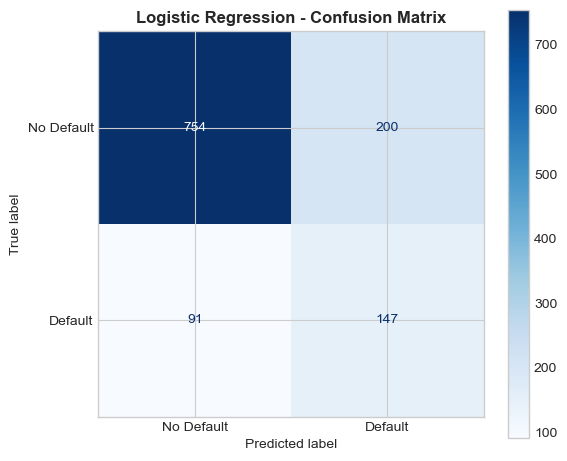


Confusion Matrix Explanation:
  TN = True Negative:  Correctly predicted no default
  FP = False Positive: Predicted default, but didn't (denied good borrower)
  FN = False Negative: Predicted no default, but did (approved bad borrower) ⚠️
  TP = True Positive:  Correctly predicted default


In [100]:
# Confusion Matrix for Logistic Regression
# Confusion matrix layout:
#                 Predicted
#              No Default | Default
# Actual No Default:  TN  |  FP
# Actual Default:     FN  |  TP

fig, ax = plt.subplots(figsize=(6, 5))

# Create confusion matrix display for Logistic Regression only
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_logreg,
    display_labels=['No Default', 'Default'],
    cmap='Blues',
    ax=ax
)
ax.set_title('Logistic Regression - Confusion Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Explanation:")
print("  TN = True Negative:  Correctly predicted no default")
print("  FP = False Positive: Predicted default, but didn't (denied good borrower)")
print("  FN = False Negative: Predicted no default, but did (approved bad borrower) ⚠️")
print("  TP = True Positive:  Correctly predicted default")

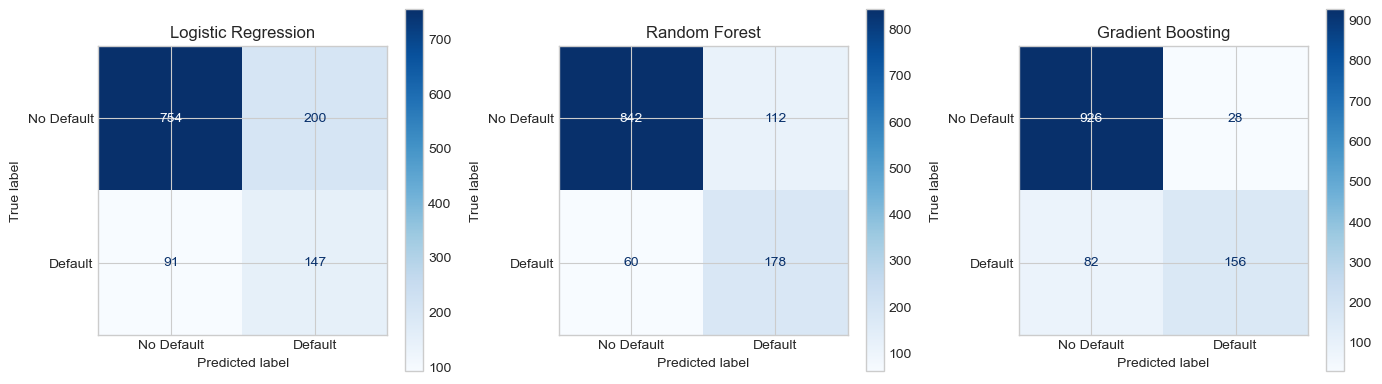

In [87]:
# Confusion matrix layout:
#                 Predicted
#              No Default | Default
# Actual No Default:  TN  |  FP
# Actual Default:     FN  |  TP
#
# TN = True Negative: Correctly predicted no default
# FP = False Positive: Predicted default, but didn't (denied good borrower)
# FN = False Negative: Predicted no default, but did (approved bad borrower) ← COSTLY!
# TP = True Positive: Correctly predicted default

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, y_pred) in zip(axes, [
    ('Logistic Regression', y_pred_logreg),
    ('Random Forest', y_pred_rf),
    ('Gradient Boosting', y_pred_gb)
]):
    # Create confusion matrix display
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=['No Default', 'Default'],
        cmap='Blues',
        ax=ax
    )
    ax.set_title(name)

plt.tight_layout()
plt.show()

In [88]:
# =============================================================================
# Extract confusion matrix values for Logistic Regression
# =============================================================================

# Get the raw confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)

# Extract individual values
TN, FP, FN, TP = cm.ravel()

print("Logistic Regression Confusion Matrix:")
print(f"  True Negatives (TN):  {TN:,} - Correctly approved good borrowers")
print(f"  False Positives (FP): {FP:,} - Wrongly denied good borrowers")
print(f"  False Negatives (FN): {FN:,} - Wrongly approved defaulters ⚠️")
print(f"  True Positives (TP):  {TP:,} - Correctly denied defaulters")

Logistic Regression Confusion Matrix:
  True Negatives (TN):  754 - Correctly approved good borrowers
  False Positives (FP): 200 - Wrongly denied good borrowers
  False Negatives (FN): 91 - Wrongly approved defaulters ⚠️
  True Positives (TP):  147 - Correctly denied defaulters


In [90]:
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# RECALL 
# Interpretation: How many defaults did we miss?
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# F1 SCORE: Harmonic mean of precision and recall
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# ACCURACY: Overall correct predictions (can be misleading!)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("Logistic Regression Metrics (at threshold = 0.5):")
print("="*50)
print(f"Precision: {precision:.3f} ({precision*100:.1f}%)")
print(f"  → Of loans flagged as risky, {precision*100:.1f}% actually defaulted")
print(f"")
print(f"Recall:    {recall:.3f} ({recall*100:.1f}%)")
print(f"  → We caught {recall*100:.1f}% of all defaults")
print(f"")
print(f"F1 Score:  {f1:.3f}")
print(f"")
print(f"Accuracy:  {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"  ⚠️ Accuracy can be misleading with imbalanced data!")

Logistic Regression Metrics (at threshold = 0.5):
Precision: 0.424 (42.4%)
  → Of loans flagged as risky, 42.4% actually defaulted

Recall:    0.618 (61.8%)
  → We caught 61.8% of all defaults

F1 Score:  0.503

Accuracy:  0.756 (75.6%)
  ⚠️ Accuracy can be misleading with imbalanced data!


In [91]:
print("Model Comparison (at threshold = 0.5):")
print("="*60)

for name, y_pred in [
    ('Logistic Regression', y_pred_logreg),
    ('Random Forest', y_pred_rf),
    ('Gradient Boosting', y_pred_gb)
]:
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

Model Comparison (at threshold = 0.5):

Logistic Regression:
              precision    recall  f1-score   support

  No Default       0.89      0.79      0.84       954
     Default       0.42      0.62      0.50       238

    accuracy                           0.76      1192
   macro avg       0.66      0.70      0.67      1192
weighted avg       0.80      0.76      0.77      1192


Random Forest:
              precision    recall  f1-score   support

  No Default       0.93      0.88      0.91       954
     Default       0.61      0.75      0.67       238

    accuracy                           0.86      1192
   macro avg       0.77      0.82      0.79      1192
weighted avg       0.87      0.86      0.86      1192


Gradient Boosting:
              precision    recall  f1-score   support

  No Default       0.92      0.97      0.94       954
     Default       0.85      0.66      0.74       238

    accuracy                           0.91      1192
   macro avg       0.88      0.

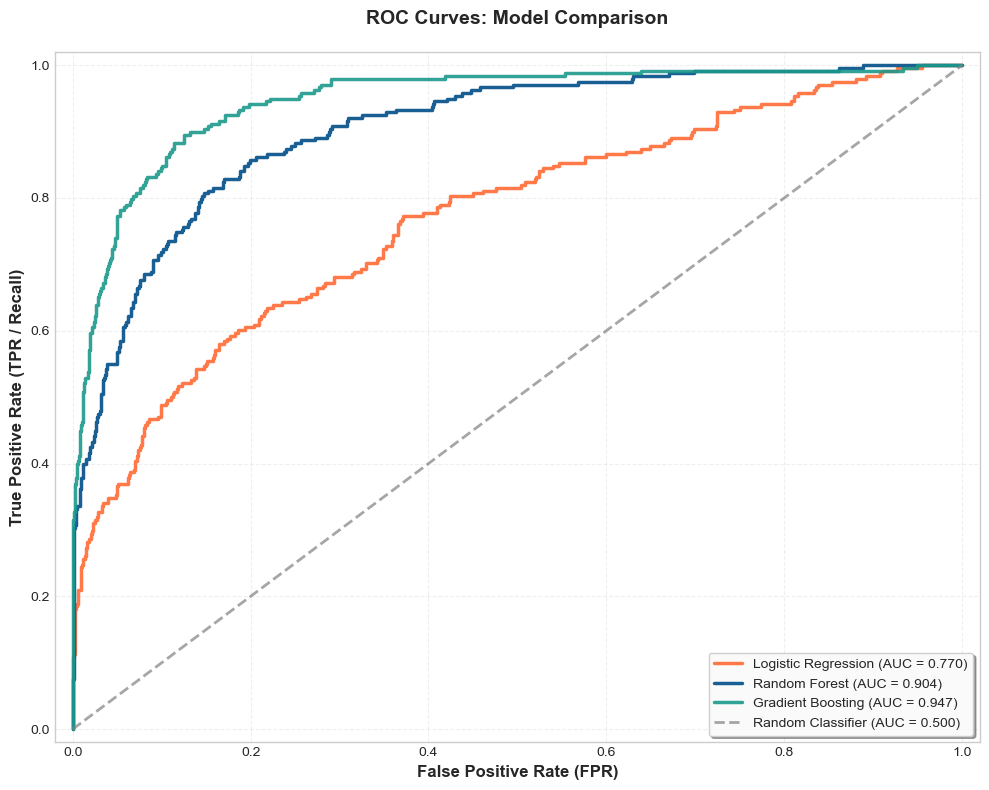


ROC-AUC SCORES SUMMARY
Logistic Regression       : AUC = 0.7696
Random Forest             : AUC = 0.9044
Gradient Boosting         : AUC = 0.9472


In [95]:
# ROC Curve and AUC - Modern Design
fig, ax = plt.subplots(figsize=(10, 8))

# Modern color palette
colors = {
    'Logistic Regression': '#FF6B35',  # Vibrant orange
    'Random Forest': '#004E89',         # Deep blue
    'Gradient Boosting': '#1B998B'      # Teal
}

# Calculate and plot ROC curve for each model
for name, y_prob in [
    ('Logistic Regression', y_prob_logreg),
    ('Random Forest', y_prob_rf),
    ('Gradient Boosting', y_prob_gb)
]:
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot with modern styling
    ax.plot(fpr, tpr, color=colors[name], linewidth=2.5, 
            label=f'{name} (AUC = {roc_auc:.3f})', alpha=0.9)

# Plot diagonal (random classifier)
ax.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2, 
        label='Random Classifier (AUC = 0.500)', alpha=0.7)

# Styling
ax.set_xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (TPR / Recall)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold', pad=20)

# Legend with better styling
ax.legend(loc='lower right', fontsize=10, frameon=True, 
          fancybox=True, shadow=True, framealpha=0.95)

# Grid for better readability
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

# Set axis limits
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

# Add AUC interpretation box
interpretation_text = (
    "AUC Interpretation:\n"
    "• AUC = Probability that model ranks a random\n"
    "  defaulter higher than a random non-defaulter\n"
    "• Higher AUC = Better ranking across all thresholds"
)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ROC-AUC SCORES SUMMARY")
print("="*80)
for name, y_prob in [
    ('Logistic Regression', y_prob_logreg),
    ('Random Forest', y_prob_rf),
    ('Gradient Boosting', y_prob_gb)
]:
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"{name:25} : AUC = {roc_auc:.4f}")
print("="*80)

In [ ]:
def calculate_cost_at_threshold(y_true, y_prob, threshold, cost_fp, cost_fn):
    """
    Calculate total cost of errors at a given threshold.
    
    Parameters:
    -----------
    y_true : array, actual labels (0 or 1)
    y_prob : array, predicted probabilities
    threshold : float, classification threshold
    cost_fp : float, cost of false positive
    cost_fn : float, cost of false negative
    
    Returns:
    --------
    dict with FP count, FN count, total cost, and metrics
    """
    # Make predictions at this threshold
    y_pred = (y_prob >= threshold).astype(int)
    
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # Calculate total cost
    total_cost = (FP * cost_fp) + (FN * cost_fn)
    
    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return {
        'threshold': threshold,
        'FP': FP,
        'FN': FN,
        'total_cost': total_cost,
        'precision': precision,
        'recall': recall
    }